In [1]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=83f609a3968346a8762e5983d45c4757797678598b8484f62c2b48535be8d24a
  Stored in directory: /root/.cache/pip/wheels/9f/34/a4/159aa12d0a510d5ff7c8f0220abbea42e5d81ecf588c4fd884
Successfully built pyspark


In [2]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark import SparkConf
from pyspark.sql.functions import count

#sc.stop()
conf = SparkConf().setMaster("local[*]").set("spark.executer.memory", "4g")

sc = SparkContext(conf=conf)
spark = SparkSession(sc).builder.getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

In [3]:
# Imprting libraries needed for analysis
from pyspark.sql.functions import regexp_replace
import matplotlib.pyplot as plt
from pyspark.sql.functions import when
import re


#from pyspark.ml.feature import Tokenizer, HashingTF, IDF 
#from pyspark.ml.classification import LogisticRegression
#from pyspark.ml import Pipeline
from pyspark.sql.functions import col

In [4]:
import pandas as pd
import numpy as np

In [83]:
#df_business = spark.read.format("csv").option("header", "true").option("multiline","true").load("/content/drive/MyDrive/yelp_business.csv")
#df_business.show()

from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import csv
try:
    with open("/content/drive/MyDrive/yelp_business.csv", "r") as file:
        reader = csv.reader(file)
        header = next(reader) # extract the header row
        data = [row for row in reader]
    df_business = spark.createDataFrame(data, schema=header)
    
    # Do some processing on the dataframe
    #df_filtered = df_business_hr.filter(col("some_column") == "some_value")
    # Do some more processing on the filtered dataframe
except csv.Error as e:
    print("An error occurred while parsing the CSV file: {}".format(e))
    # Handle the error and move on, for example:
    df_business = spark.createDataFrame([], df_business.schema) # create an empty dataframe with the same schema as df_business_hr
except Exception as e:
    print("An error occurred while processing the data: {}".format(e))
    # Handle the error and move on, for example:
    df_business = spark.createDataFrame([], df_business.schema) # create an empty dataframe with the same schema as df_business_hr

df_business.show()

+--------------------+--------------------+------------------+--------------------+--------------+-----+-----------+-------------+--------------+-----+------------+-------+--------------------+
|         business_id|                name|      neighborhood|             address|          city|state|postal_code|     latitude|     longitude|stars|review_count|is_open|          categories|
+--------------------+--------------------+------------------+--------------------+--------------+-----+-----------+-------------+--------------+-----+------------+-------+--------------------+
|FYWN1wneV18bWNgQj...|  "Dental by Design"|                  |"4855 E Warner Rd...|     Ahwatukee|   AZ|      85044|   33.3306902|  -111.9785992|  4.0|          22|      1|Dentists;General ...|
|He-G7vWjzVUysIKrf...|"Stephen Szabo Sa...|                  |"3101 Washington Rd"|      McMurray|   PA|      15317|   40.2916853|   -80.1048999|  3.0|          11|      1|Hair Stylists;Hai...|
|KQPW8lFf1y5BT2Mxi...|"Western

In [6]:
df_business_attr = spark.read.format("csv").option("header", "true").option("multiline","true").load("/content/drive/MyDrive/yelp_business_attributes.csv")
df_business_attr.show(5)

+--------------------+----------------+-----------------+--------------------------+----------------------+----------------------+-------------------------+-------------------+---------------------+--------------------------+---------------------------------+-----------------------+-----------------------+----------------------+----------------------------+-----------------------+-------------------------------+----------------------+-----------+--------------------+-----------+-------+-----+----------+-----------------+--------+----------------------+--------------+-------------+----------+-----------+-------------+-----------------+-----------------+---------------+----------------+--------------+-----------------+---------------+----------------+---------------+------------------------+------+----+-----------------------+------------------+---------+--------------+-----------------------+--------------+-------------------+-----------------+------------------+-----------------+------

In [7]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import csv
try:
    with open("/content/drive/MyDrive/yelp_business_hours.csv", "r") as file:
        reader = csv.reader(file)
        header = next(reader) # extract the header row
        data = [row for row in reader]
    df_business_hr = spark.createDataFrame(data, schema=header)
    
    # Do some processing on the dataframe
    #df_filtered = df_business_hr.filter(col("some_column") == "some_value")
    # Do some more processing on the filtered dataframe
except csv.Error as e:
    print("An error occurred while parsing the CSV file: {}".format(e))
    # Handle the error and move on, for example:
    df_business_hr = spark.createDataFrame([], df_business_hr.schema) # create an empty dataframe with the same schema as df_business_hr
except Exception as e:
    print("An error occurred while processing the data: {}".format(e))
    # Handle the error and move on, for example:
    df_business_hr = spark.createDataFrame([], df_business_hr.schema) # create an empty dataframe with the same schema as df_business_hr

df_business_hr.show()


+--------------------+----------+----------+----------+----------+----------+----------+---------+
|         business_id|    monday|   tuesday| wednesday|  thursday|    friday|  saturday|   sunday|
+--------------------+----------+----------+----------+----------+----------+----------+---------+
|FYWN1wneV18bWNgQj...| 7:30-17:0| 7:30-17:0| 7:30-17:0| 7:30-17:0| 7:30-17:0|      None|     None|
|He-G7vWjzVUysIKrf...|  9:0-20:0|  9:0-20:0|  9:0-20:0|  9:0-20:0|  9:0-16:0|  8:0-16:0|     None|
|KQPW8lFf1y5BT2Mxi...|      None|      None|      None|      None|      None|      None|     None|
|8DShNS-LuFqpEWIp0...| 10:0-21:0| 10:0-21:0| 10:0-21:0| 10:0-21:0| 10:0-21:0| 10:0-21:0|11:0-19:0|
|PfOCPjBrlQAnz__NX...|  11:0-1:0|  11:0-1:0|  11:0-1:0|  11:0-1:0|  11:0-1:0|  11:0-2:0| 11:0-0:0|
|o9eMRCWt5PkpLDE0g...|  18:0-0:0|  18:0-0:0|  18:0-0:0|  18:0-0:0|  18:0-0:0|  18:0-0:0|     None|
|kCoE3jvEtg6UVz5SO...|  8:0-17:0|  8:0-17:0|  8:0-17:0|  8:0-17:0|  8:0-17:0|      None|     None|
|OD2hnuuTJ

In [8]:
df_checkin = spark.read.format("csv").option("header", "true").option("multiline","true").load("/content/drive/MyDrive/yelp_checkin.csv")
df_checkin.show()

+--------------------+-------+-----+--------+
|         business_id|weekday| hour|checkins|
+--------------------+-------+-----+--------+
|3Mc-LxcqeguOXOVT_...|    Tue| 0:00|      12|
|SVFx6_epO22bZTZnK...|    Wed| 0:00|       4|
|vW9aLivd4-IorAfSt...|    Tue|14:00|       1|
|tEzxhauTQddACyqdJ...|    Fri|19:00|       1|
|CEyZU32P-vtMhgqRC...|    Tue|17:00|       1|
|9dn5pee_n2dWQfN57...|    Sun| 3:00|       5|
|6Zk5F7fsTr8n2CJTl...|    Wed| 1:00|       4|
|OE_IDW5w_W97sBcZv...|    Sat| 1:00|       1|
|gy5pr5bFAjOL5rERS...|    Sat|15:00|       1|
|r2-eAhGANXlcgQy89...|    Mon|19:00|       1|
|wiBxwslJAGDdZ2nmL...|    Mon|16:00|       1|
|08jURVR_eDvXq9scd...|    Sat|23:00|       1|
|BlWPjh2WuvQSlmYmg...|    Sun| 0:00|       1|
|6DO_2jivyxcL6SXGP...|    Wed|23:00|       1|
|wrJROwvVKHvdMVIZO...|    Thu|21:00|       3|
|uU8up3hGwW9qnzQD1...|    Fri| 0:00|       1|
|JHPq9KvMuJaC7CPAT...|    Sun|16:00|       1|
|vyzfT3_KzLi8WmInw...|    Thu| 9:00|       1|
|E4T0rQBJa0e4HIliB...|    Thu|23:0

In [36]:
#"review_id","user_id","business_id","stars","date","text","useful","funny","cool"
#1. Clean the dataset
df_review = spark.read.format("csv").option("header", "true").option("multiline","true").load("/content/drive/MyDrive/yelp_review.csv")

df_review.show()

df_user = spark.read.format("csv").option("header", "true").option("multiline","true").load("/content/drive/MyDrive/yelp_user.csv")

df_user.show()

df_business_attr = spark.read.format("csv").option("header", "true").option("multiline","true").load("/content/drive/MyDrive/yelp_business_attributes.csv")

df_business_attr.show()

+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+
|           review_id|             user_id|         business_id|stars|      date|                text|useful|funny|cool|
+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+
|vkVSCC7xljjrAI4UG...|bv2nCi5Qv5vroFiqK...|AEx2SYEUJmTxVVB18...|    5|2016-05-28|Super simple plac...|     0|    0|   0|
|n6QzIUObkYshz4dz2...|bv2nCi5Qv5vroFiqK...|VR6GpWIda3SfvPC-l...|    5|2016-05-28|Small unassuming ...|     0|    0|   0|
|MV3CcKScW05u5LVfF...|bv2nCi5Qv5vroFiqK...|CKC0-MOWMqoeWf6s-...|    5|2016-05-28|Lester's is locat...|     0|    0|   0|
|IXvOzsEMYtiJI0CAR...|bv2nCi5Qv5vroFiqK...|ACFtxLv8pGrrxMm6E...|    4|2016-05-28|Love coming here....|     0|    0|   0|
|L_9BTb55X0GDtThi6...|bv2nCi5Qv5vroFiqK...|s2I_Ni76bjJNK9yG6...|    4|2016-05-28|Had their chocola...|     0|    0|   0|
|HRPm3vEZ_F-33TYVT...|_4iMDXbXZ1

In [10]:
df_tip = spark.read.format("csv").option("header", "true").option("multiline","true").load("/content/drive/MyDrive/yelp_tip.csv")

df_tip.show()

+--------------------+----------+-----+--------------------+--------------------+
|                text|      date|likes|         business_id|             user_id|
+--------------------+----------+-----+--------------------+--------------------+
|Great breakfast l...|2015-08-12|    0|jH19V2I9fIslnNhDz...|ZcLKXikTHYOnYt5VY...|
|Nice place. Great...|2014-06-20|    0|dAa0hB2yrnHzVmsCk...|oaYhjqBbh18ZhU0bp...|
|Happy hour 5-7 Mo...|2016-10-12|    0|dAa0hB2yrnHzVmsCk...|ulQ8Nyj7jCUR8M83S...|
|Parking is a prem...|2017-01-28|    0|ESzO3Av0b1_TzKOiq...|ulQ8Nyj7jCUR8M83S...|
|Homemade pasta is...|2017-02-25|    0|k7WRPbDd7rztjHcGG...|ulQ8Nyj7jCUR8M83S...|
|Excellent service...|2017-04-08|    0|k7WRPbDd7rztjHcGG...|ulQ8Nyj7jCUR8M83S...|
|Come early on Sun...|2016-07-03|    0|SqW3igh1_Png336VI...|ulQ8Nyj7jCUR8M83S...|
|    Love their soup!|2016-01-07|    0|KNpcPGqDORDdvtekX...|ulQ8Nyj7jCUR8M83S...|
|Soups are fantastic!|2016-05-22|    0|KNpcPGqDORDdvtekX...|ulQ8Nyj7jCUR8M83S...|
|Thursday night 

In [11]:
# Let us print schema for all
df_review.printSchema()

# Creating another column named 'label'. in which starts column have been converted to numeric
df_review = df_review.withColumn("stars", regexp_replace("stars", "[^0-9.]+", ""))
df_review = df_review.withColumn("label", df_review["stars"].cast("double"))
df_review.show()

# n_rows = df_review.count()
# n_cols = len(df_review.columns)

root
 |-- review_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- stars: string (nullable = true)
 |-- date: string (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: string (nullable = true)
 |-- funny: string (nullable = true)
 |-- cool: string (nullable = true)

+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+-----+
|           review_id|             user_id|         business_id|stars|      date|                text|useful|funny|cool|label|
+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+-----+
|vkVSCC7xljjrAI4UG...|bv2nCi5Qv5vroFiqK...|AEx2SYEUJmTxVVB18...|    5|2016-05-28|Super simple plac...|     0|    0|   0|  5.0|
|n6QzIUObkYshz4dz2...|bv2nCi5Qv5vroFiqK...|VR6GpWIda3SfvPC-l...|    5|2016-05-28|Small unassuming ...|     0|    0|   0|  5.0|
|MV3CcKScW05u5LV

# Data Exploratory Analysis - REVIEWS


In [12]:
#####  1: BAR CHART FOR NUMBER OF STARS ######
count_1_star = df_review.filter(df_review.label == 1.0).count()
count_2_star = df_review.filter(df_review.label == 2.0).count()
count_3_star = df_review.filter(df_review.label == 3.0).count()
count_4_star = df_review.filter(df_review.label == 4.0).count()
count_5_star = df_review.filter(df_review.label == 5.0).count()

print("Count of 1-star ratings:", count_1_star)
print("Count of 2-star ratings:", count_2_star)
print("Count of 3-star ratings:", count_3_star)
print("Count of 4-star ratings:", count_4_star)
print("Count of 5-star ratings:", count_5_star)

Count of 1-star ratings: 747104
Count of 2-star ratings: 445838
Count of 3-star ratings: 619825
Count of 4-star ratings: 1225921
Count of 5-star ratings: 2255090


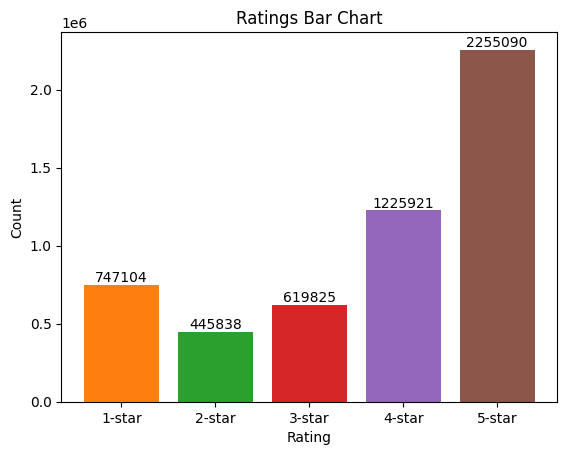

In [13]:
# Create a bar plot
labels = ['1-star', '2-star', '3-star', '4-star', '5-star']
counts = [count_1_star, count_2_star, count_3_star, count_4_star, count_5_star]
colors = ['#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

ax = plt.axes()
ax.bar(labels, counts, color=colors)

# Add labels to the bars
for i, count in enumerate(counts):
    ax.text(i, count+1, str(count), ha='center', va='bottom')

# Add labels and title
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Ratings Bar Chart')

# Display the plot
plt.show()

In [39]:
#####  2: PIE CHART FOR SENTIMENT OF REVIEWS ######
df_review = df_review.withColumn("sentiment", when(df_review["stars"] >= 4, "positive")
                                              .when(df_review["stars"] <= 2, "negative")
                                              .otherwise("neutral"))

count_positive = df_review.filter(df_review.sentiment == "positive").count()
count_negative = df_review.filter(df_review.sentiment == "negative").count()
count_neutral = df_review.filter(df_review.sentiment == "neutral").count()

print("Count of negative reviews:", count_negative)
print("Count of positive reviews:", count_positive)
print("Count of neutral reviews:", count_neutral)

Count of negative reviews: 1238438
Count of positive reviews: 3485328
Count of neutral reviews: 703247


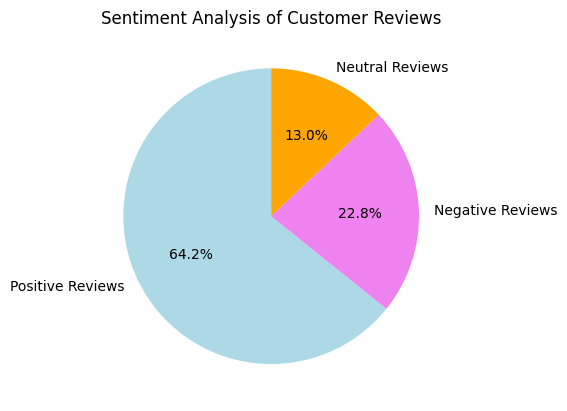

In [40]:
# Define the values
values = [count_positive, count_negative, count_neutral]
labels = ['Positive Reviews', 'Negative Reviews', 'Neutral Reviews']

# Define the colors
colors = ['lightblue', 'violet', 'orange']

# Create the pie chart
plt.pie(values, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

# Add a title
plt.title('Sentiment Analysis of Customer Reviews')

# Show the chart
plt.show()

In [41]:
#####  3: Dsitribution of ratings amongst different stars ######
df_review = df_review.withColumn('useful', regexp_replace('useful', '[^0-9]', ''))
df_review = df_review.withColumn('cool', regexp_replace('cool', '[^0-9]', ''))
df_review = df_review.withColumn('funny', regexp_replace('funny', '[^0-9]', ''))
#df_review = df_review.withColumn("useful", df_review["useful"].cast("single"))
#df_review = df_review.withColumn("cool", df_review["cool"].cast("single"))
#df_review = df_review.withColumn("funny", df_review["funny"].cast("single"))
df_review.show()


# Select the columns and group by them to count the number of rows in each group
# grouped = df_review.select('useful', 'funny', 'cool').groupBy('useful', 'funny', 'cool').count().limit(100)

# grouped.show()

+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+---------+
|           review_id|             user_id|         business_id|stars|      date|                text|useful|funny|cool|sentiment|
+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+---------+
|vkVSCC7xljjrAI4UG...|bv2nCi5Qv5vroFiqK...|AEx2SYEUJmTxVVB18...|    5|2016-05-28|Super simple plac...|     0|    0|   0| positive|
|n6QzIUObkYshz4dz2...|bv2nCi5Qv5vroFiqK...|VR6GpWIda3SfvPC-l...|    5|2016-05-28|Small unassuming ...|     0|    0|   0| positive|
|MV3CcKScW05u5LVfF...|bv2nCi5Qv5vroFiqK...|CKC0-MOWMqoeWf6s-...|    5|2016-05-28|Lester's is locat...|     0|    0|   0| positive|
|IXvOzsEMYtiJI0CAR...|bv2nCi5Qv5vroFiqK...|ACFtxLv8pGrrxMm6E...|    4|2016-05-28|Love coming here....|     0|    0|   0| positive|
|L_9BTb55X0GDtThi6...|bv2nCi5Qv5vroFiqK...|s2I_Ni76bjJNK9yG6...|    4|2016-05-28|Ha

In [21]:
df_review.show()

+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+-----+---------+
|           review_id|             user_id|         business_id|stars|      date|                text|useful|funny|cool|label|sentiment|
+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+-----+---------+
|vkVSCC7xljjrAI4UG...|bv2nCi5Qv5vroFiqK...|AEx2SYEUJmTxVVB18...|    5|2016-05-28|Super simple plac...|     0|    0|   0|  5.0| positive|
|n6QzIUObkYshz4dz2...|bv2nCi5Qv5vroFiqK...|VR6GpWIda3SfvPC-l...|    5|2016-05-28|Small unassuming ...|     0|    0|   0|  5.0| positive|
|MV3CcKScW05u5LVfF...|bv2nCi5Qv5vroFiqK...|CKC0-MOWMqoeWf6s-...|    5|2016-05-28|Lester's is locat...|     0|    0|   0|  5.0| positive|
|IXvOzsEMYtiJI0CAR...|bv2nCi5Qv5vroFiqK...|ACFtxLv8pGrrxMm6E...|    4|2016-05-28|Love coming here....|     0|    0|   0|  4.0| positive|
|L_9BTb55X0GDtThi6...|bv2nCi5Qv5vroFiqK..

In [42]:
import pyspark.sql.functions as F
import matplotlib.pyplot as plt

# Aggregate the data by sentiment category and count the number of useful, cool, and funny
agg_df = df_review.groupBy('sentiment').agg(
    F.sum('useful').alias('useful_count'),
    F.sum('cool').alias('cool_count'),
    F.sum('funny').alias('funny_count'),
    F.count('review_id').alias('total_count')
)

# Extract the data from the aggregated DataFrame
sentiments = [row['sentiment'] for row in agg_df.collect()]
useful_counts = [row['useful_count'] for row in agg_df.collect()]
cool_counts = [row['cool_count'] for row in agg_df.collect()]
funny_counts = [row['funny_count'] for row in agg_df.collect()]
total_count = funny_counts = [row['total_count'] for row in agg_df.collect()]



In [43]:
agg_df.show()

+---------+--------------------+--------------------+--------------------+-----------+
|sentiment|        useful_count|          cool_count|         funny_count|total_count|
+---------+--------------------+--------------------+--------------------+-----------+
| positive|3.009058076473183...|4.120027511918469...|4.385420420450390...|    3485328|
|  neutral|3.498454102023491E43|4.146147125150113E97|2.195113042695436E86|     703244|
| negative|1.200971630040511...|4.237336107448471E93|2.034172657159897...|    1238438|
+---------+--------------------+--------------------+--------------------+-----------+



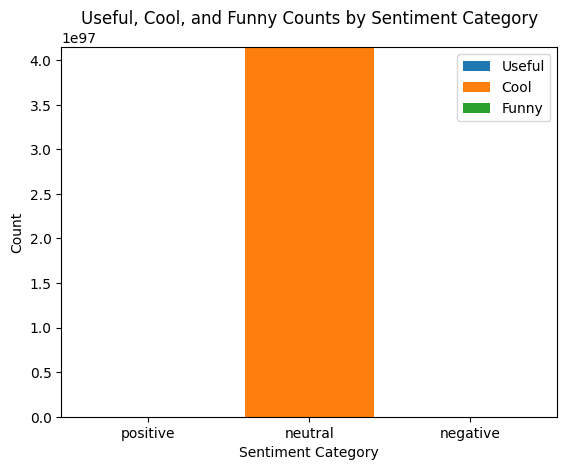

In [44]:

# Create a bar plot
fig, ax = plt.subplots()
ax.bar(sentiments, useful_counts, label='Useful')
ax.bar(sentiments, cool_counts, bottom=useful_counts, label='Cool')
ax.bar(sentiments, funny_counts, bottom=[sum(x) for x in zip(useful_counts, cool_counts)], label='Funny')
ax.set_xlabel('Sentiment Category')
ax.set_ylabel('Count')
ax.set_title('Useful, Cool, and Funny Counts by Sentiment Category')
ax.legend()
#ax.set_yticks([0, 50, 100, 150, 200])
# Add labels to the bars
#for i, v in enumerate(useful_counts):
#    ax.text(i - 0.2, v + 5, str(v))
#for i, v in enumerate(cool_counts):
#    ax.text(i - 0.2, v + useful_counts[i] + 5, str(v))
#for i, v in enumerate(funny_counts):
#    ax.text(i - 0.2, v + useful_counts[i] + cool_counts[i] + 5, str(v))

# Show the plot
plt.show()
# Show the plot
plt.show()

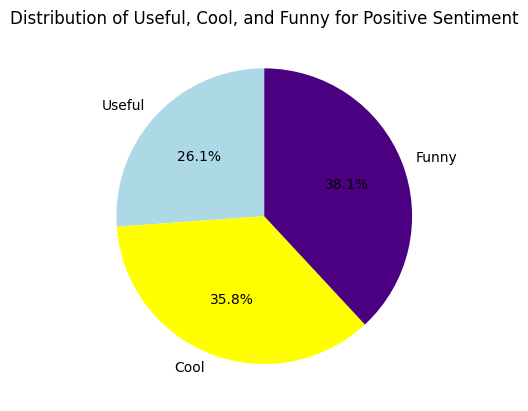

In [75]:
# Define the data
labels = ['Useful', 'Cool', 'Funny']
sizes_positive = [3.009058076473183, 4.120027511918469, 4.385420420450390]
sizes_neutral = [3.4984541020234, 4.146147125150113, 2.1951130426954]
sizes_neutral = np.nan_to_num(sizes_neutral)
sizes_negative = [1.20097163004051, 4.23733610744847, 2.03417265715989]
sizes_negative = np.nan_to_num(sizes_negative)

# Create the pie chart for positive
fig, ax = plt.subplots()
colors = ['lightblue', 'yellow', 'indigo']
ax.pie(sizes_positive, colors=colors, labels=labels, autopct='%1.1f%%', startangle=90)
ax.set_title('Distribution of Useful, Cool, and Funny for Positive Sentiment')

# Show the plot
plt.show()


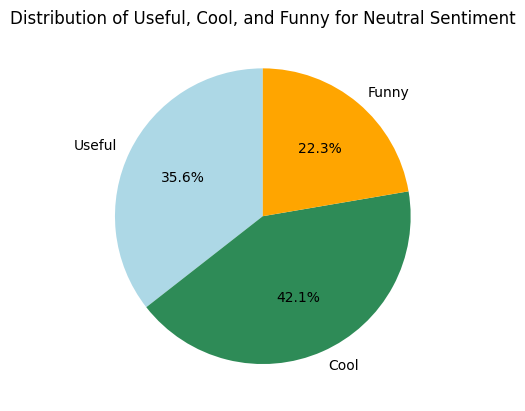

In [78]:
# Create the pie chart for Neutral
fig, ax = plt.subplots()
colors = ['lightblue', 'seagreen', 'orange']
ax.pie(sizes_neutral, colors=colors, labels=labels, autopct='%1.1f%%', startangle=90)
ax.set_title('Distribution of Useful, Cool, and Funny for Neutral Sentiment')

# Show the plot
plt.show()


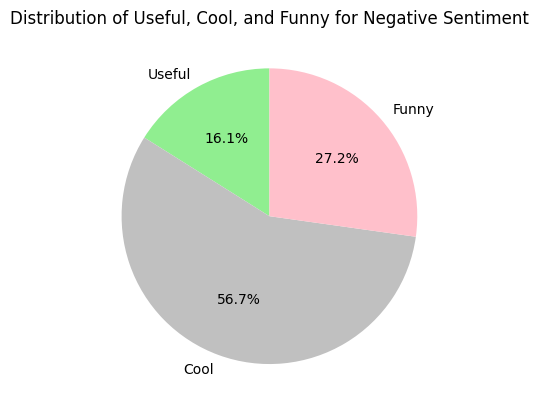

In [72]:

# Create the pie chart for Negative
fig, ax = plt.subplots()
colors = ['lightgreen', 'silver', 'pink']
ax.pie(sizes_negative, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax.set_title('Distribution of Useful, Cool, and Funny for Negative Sentiment')

# Show the plot
plt.show()

### Data Exploratory Analysis - Business

In [95]:
######  1: BAR CHART FOR NUMBER OF STARS (Business) ######

# Creating another column named 'label'. in which starts column have been converted to numeric
df_business = df_business.withColumn("stars", regexp_replace("stars", "[^0-9.]+", ""))
df_business = df_business.withColumn("label", df_business["stars"].cast("double"))
#df_business.show()

df_business = df_business.withColumn("StarBucket", when(df_business["stars"] > 4, "5 star")
                                              .when(df_business["stars"] >3 , "4 star")
                                              .when(df_business["stars"] >2 , "3 star")
                                              .when(df_business["stars"] >1 , "2 star")
                                              .otherwise("1 star"))

count_1_star = df_business.filter(df_business.StarBucket == "1 star").count()
count_2_star = df_business.filter(df_business.StarBucket == "2 star").count()
count_3_star = df_business.filter(df_business.StarBucket == "3 star").count()
count_4_star = df_business.filter(df_business.StarBucket == "4 star").count()
count_5_star = df_business.filter(df_business.StarBucket == "5 star").count()



print("Count of 1-star ratings:", count_1_star)
print("Count of 2-star ratings:", count_2_star)
print("Count of 3-star ratings:", count_3_star)
print("Count of 4-star ratings:", count_4_star)
print("Count of 5-star ratings:", count_5_star)

Count of 1-star ratings: 8091
Count of 2-star ratings: 25468
Count of 3-star ratings: 55180
Count of 4-star ratings: 58288
Count of 5-star ratings: 27540


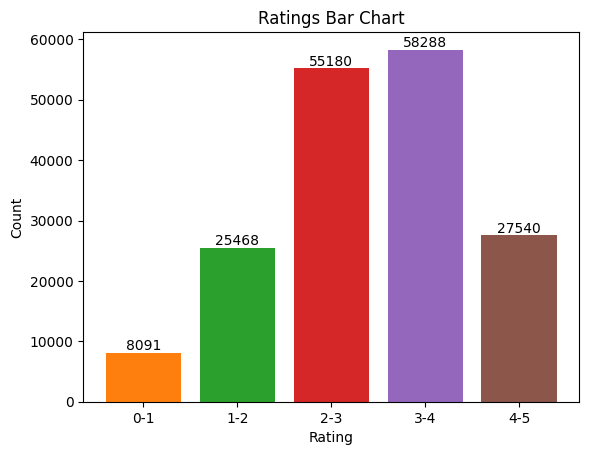

In [96]:
# Create a bar plot
labels = ['0-1', '1-2', '2-3', '3-4', '4-5']
counts = [count_1_star, count_2_star, count_3_star, count_4_star, count_5_star]
colors = ['#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

ax = plt.axes()
ax.bar(labels, counts, color=colors)

# Add labels to the bars
for i, count in enumerate(counts):
    ax.text(i, count+1, str(count), ha='center', va='bottom')

# Add some labels and a title
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Ratings Bar Chart')

# Display the plot
plt.show()

+-----+----------+-----+------------------+
|state|StarBucket|count|        percentage|
+-----+----------+-----+------------------+
|     |    5 star|    1|             100.0|
|   01|    2 star|    1|              10.0|
|   01|    3 star|    5|              50.0|
|   01|    4 star|    3|              30.0|
|   01|    5 star|    1|              10.0|
|    3|    5 star|    1|             100.0|
|   30|    3 star|    1|             100.0|
|    6|    3 star|    2| 66.66666666666666|
|    6|    5 star|    1| 33.33333333333333|
|   AB|    5 star|    1|             100.0|
|  ABE|    3 star|    1| 33.33333333333333|
|  ABE|    4 star|    2| 66.66666666666666|
|   AK|    2 star|    1|             100.0|
|   AL|    5 star|    1|             100.0|
|   AR|    1 star|    1|              50.0|
|   AR|    5 star|    1|              50.0|
|   AZ|    1 star| 2548|4.8799172635691574|
|   AZ|    2 star| 7397|14.166698586585975|
|   AZ|    3 star|14202|27.199601639407057|
|   AZ|    4 star|16369|31.34982

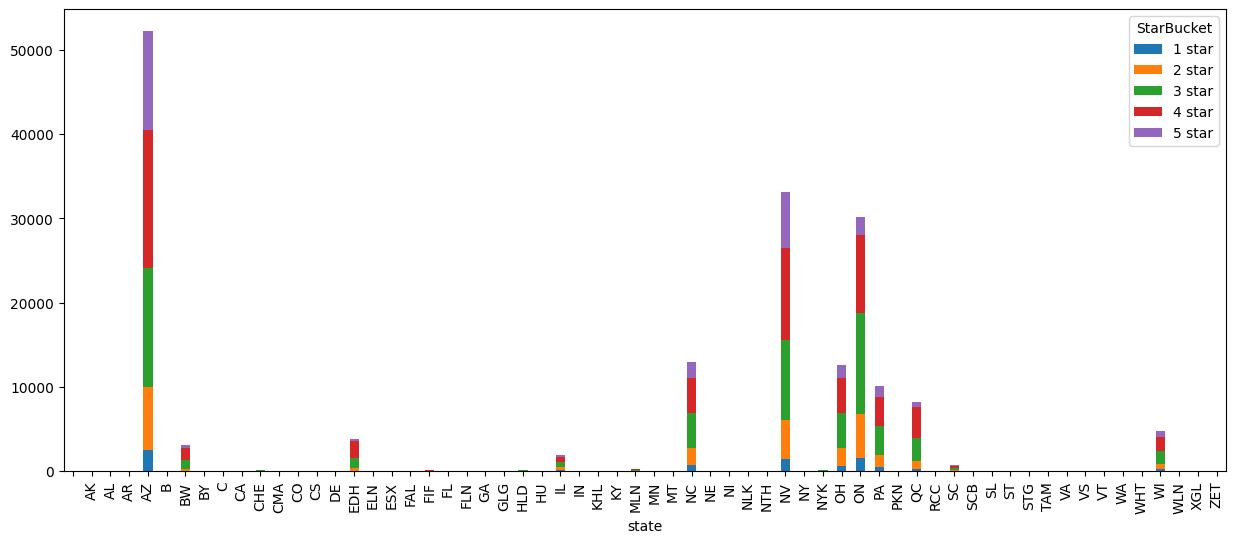

In [91]:
import pyspark.sql.functions as F
from pyspark.sql.functions import sum as spark_sum
from pyspark.sql.window import Window


# assume your dataframe is called 'df'
stars_per_state = df_business.groupBy('state', 'StarBucket').count().orderBy('state', 'StarBucket')

#stars_per_state = df_business.groupBy('state', 'StarBucket').agg(spark_sum('count').alias('total_count'))
stars_per_state = stars_per_state.withColumn('percentage', stars_per_state['count'] / spark_sum('count').over(Window.partitionBy('state')) * 100)
stars_per_state.show()

# filter the dataframe to remove rows with certain state values
states_to_remove = ['01', '3', '30', '6', 'AB', 'ABE']
stars_per_state_filtered = stars_per_state.filter(~stars_per_state['state'].isin(states_to_remove))

# convert to Pandas dataframe for plotting
stars_per_state_filtered_pd = stars_per_state_filtered.toPandas()
stars_per_state_filtered.show()

# convert to Pandas dataframe for plotting
# stars_per_state_pd = stars_per_state.toPandas()

fig, ax = plt.subplots(figsize=(15, 6))

# plot the data using a bar chart
stars_per_state_filtered_pd.pivot(index='state', columns='StarBucket', values='count').plot(kind='bar', stacked=True, ax=ax)

# add labels to the bars
#for p in ax.containers:
#    for q in p.patches:
#        if q.get_height() > 0:
#            ax.annotate(str(int(q.get_height())), xy=(q.get_x() + q.get_width() / 2, q.get_y() + q.get_height() / 2),
#                        xytext=(0, 0), textcoords='offset points', ha='center', va='center')


# show the plot
plt.show()

### DATA EXPLORATORY ANALYSIS - REVIEWS + BUSINESSES

In [51]:
merged_df = df_review.join(df_business, df_review.business_id == df_business.business_id, "inner")

In [52]:
merged_df.show()

+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+-----+---------+----------+--------------------+--------------------+------------+--------------------+---------+-----+-----------+---------+----------+-----+------------+-------+--------------------+-----+----------+
|           review_id|             user_id|         business_id|stars|      date|                text|useful|funny|cool|label|sentiment|StarBucket|         business_id|                name|neighborhood|             address|     city|state|postal_code| latitude| longitude|stars|review_count|is_open|          categories|label|StarBucket|
+--------------------+--------------------+--------------------+-----+----------+--------------------+------+-----+----+-----+---------+----------+--------------------+--------------------+------------+--------------------+---------+-----+-----------+---------+----------+-----+------------+-------+--------------------+----

In [53]:
# Get the row count
row_count = merged_df.count()

# Get the column count
column_count = len(merged_df.columns)

# Print the row and column count
print("Row count: ", row_count)
print("Column count: ", column_count)

Row count:  5261668
Column count:  27


### DATA EXPLORATORY ANALYSIS - USERS


In [56]:
df_user.show()
# Get the row count
row_count = df_user.count()

# Get the column count
column_count = len(df_user.columns)

# Print the row and column count
print("Row count: ", row_count)
print("Column count: ", column_count)

+--------------------+-------+------------+-------------+--------------------+------+-----+----+----+-----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+
|             user_id|   name|review_count|yelping_since|             friends|useful|funny|cool|fans|elite|average_stars|compliment_hot|compliment_more|compliment_profile|compliment_cute|compliment_list|compliment_note|compliment_plain|compliment_cool|compliment_funny|compliment_writer|compliment_photos|
+--------------------+-------+------------+-------------+--------------------+------+-----+----+----+-----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+
|JJ-aSuM4pCFPdkfoZ...|  Chris|          10|   2013-09-24|0njfJmB-7n84DlIgU...|    

In [57]:
# Check for duplicates based on specific columns
duplicates = df_user.dropDuplicates(["user_id"])

# Count the number of duplicates
num_duplicates = df_user.count() - duplicates.count()

# Print the number of duplicates
print("Number of duplicates: ", num_duplicates)

Number of duplicates:  0


In [97]:
# Elite vs Non Elite users
count_non_elite = df_user.filter(df_user.elite == "None").count()
count_elite = df_user.filter(df_user.elite != "None").count()

print("Count of non elite users:", count_non_elite)
print("Count of elite users:", count_elite)

Count of non elite users: 1265282
Count of elite users: 60818


+--------------------+-------+------------+-------------+--------------------+------+-----+----+----+-----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+-----+
|             user_id|   name|review_count|yelping_since|             friends|useful|funny|cool|fans|elite|average_stars|compliment_hot|compliment_more|compliment_profile|compliment_cute|compliment_list|compliment_note|compliment_plain|compliment_cool|compliment_funny|compliment_writer|compliment_photos|label|
+--------------------+-------+------------+-------------+--------------------+------+-----+----+----+-----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+-----+
|JJ-aSuM4pCFPdkfoZ...|  Chris|          10|   2013-09-24|0njfJmB

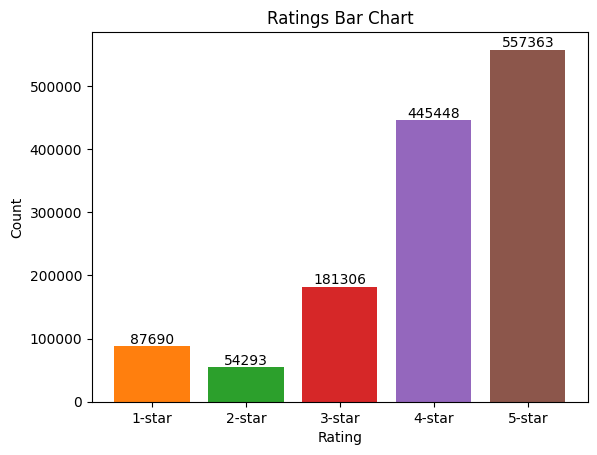

In [93]:
# Creating another column named 'label'. in which starts column have been converted to numeric
df_user = df_user.withColumn("average_stars", regexp_replace("average_stars", "[^0-9.]+", ""))
df_user = df_user.withColumn("label", df_user["average_stars"].cast("double"))
df_user.show()

df_user = df_user.withColumn("StarBucket", when(df_user["label"] > 4, "5 star")
                                              .when(df_user["label"] >3 , "4 star")
                                              .when(df_user["label"] >2 , "3 star")
                                              .when(df_user["label"] >1 , "2 star")
                                              .otherwise("1 star"))

count_1_star = df_user.filter(df_user.StarBucket == "1 star").count()
count_2_star = df_user.filter(df_user.StarBucket == "2 star").count()
count_3_star = df_user.filter(df_user.StarBucket == "3 star").count()
count_4_star = df_user.filter(df_user.StarBucket == "4 star").count()
count_5_star = df_user.filter(df_user.StarBucket == "5 star").count()

print("Count of 1-star users:", count_1_star)
print("Count of 2-star users:", count_2_star)
print("Count of 3-star users:", count_3_star)
print("Count of 4-star users:", count_4_star)
print("Count of 5-star users:", count_5_star)

# Create a bar plot
labels = ['1-star', '2-star', '3-star', '4-star', '5-star']
counts = [count_1_star, count_2_star, count_3_star, count_4_star, count_5_star]
colors = ['#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

ax = plt.axes()
ax.bar(labels, counts, color=colors)

# Add labels to the bars
for i, count in enumerate(counts):
    ax.text(i, count+1, str(count), ha='center', va='bottom')

# Add some labels and a title
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Ratings Bar Chart')

# Display the plot
plt.show()